In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pydaptivefiltering as pdf
def demo_volterra_system(n_samples=3000, memory=3, noise_std=0.01):
    rng = np.random.default_rng(2026)
    x = rng.standard_normal(n_samples)
    
    # Criando um sistema com termos lineares e quadráticos
    # d(k) = 0.5*x(k) - 0.2*x(k-2) + 0.3*x(k)^2 + 0.15*x(k)*x(k-1)
    d = np.zeros(n_samples)
    for k in range(memory, n_samples):
        linear_part = 0.5 * x[k] - 0.2 * x[k-2]
        quadratic_part = 0.3 * (x[k]**2) + 0.15 * x[k] * x[k-1]
        noise = noise_std * rng.standard_normal()
        d[k] = linear_part + quadratic_part + noise
        
    return x, d

In [2]:
# 1. Gerar dados
memory_length = 3
x, d = demo_volterra_system(n_samples=5000, memory=memory_length, noise_std=0.05)

# 2. Instanciar Volterra LMS
# Total de coeficientes: L + L*(L+1)/2 = 3 + (3*4)/2 = 9
volterra = pdf.VolterraLMS(memory=memory_length, step=0.005)

# 3. Otimizar
res = volterra.optimize(x, d, verbose=True)

# 4. Extrair métricas
y = res['outputs'].real
e = res['errors'].real
mse_dB = 10 * np.log10(np.mean(e[-500:]**2))

print(f"MSE Final (Regime Permanente): {mse_dB:.2f} dB")

Volterra LMS Adaptation completed in 23.916 ms
MSE Final (Regime Permanente): -25.67 dB


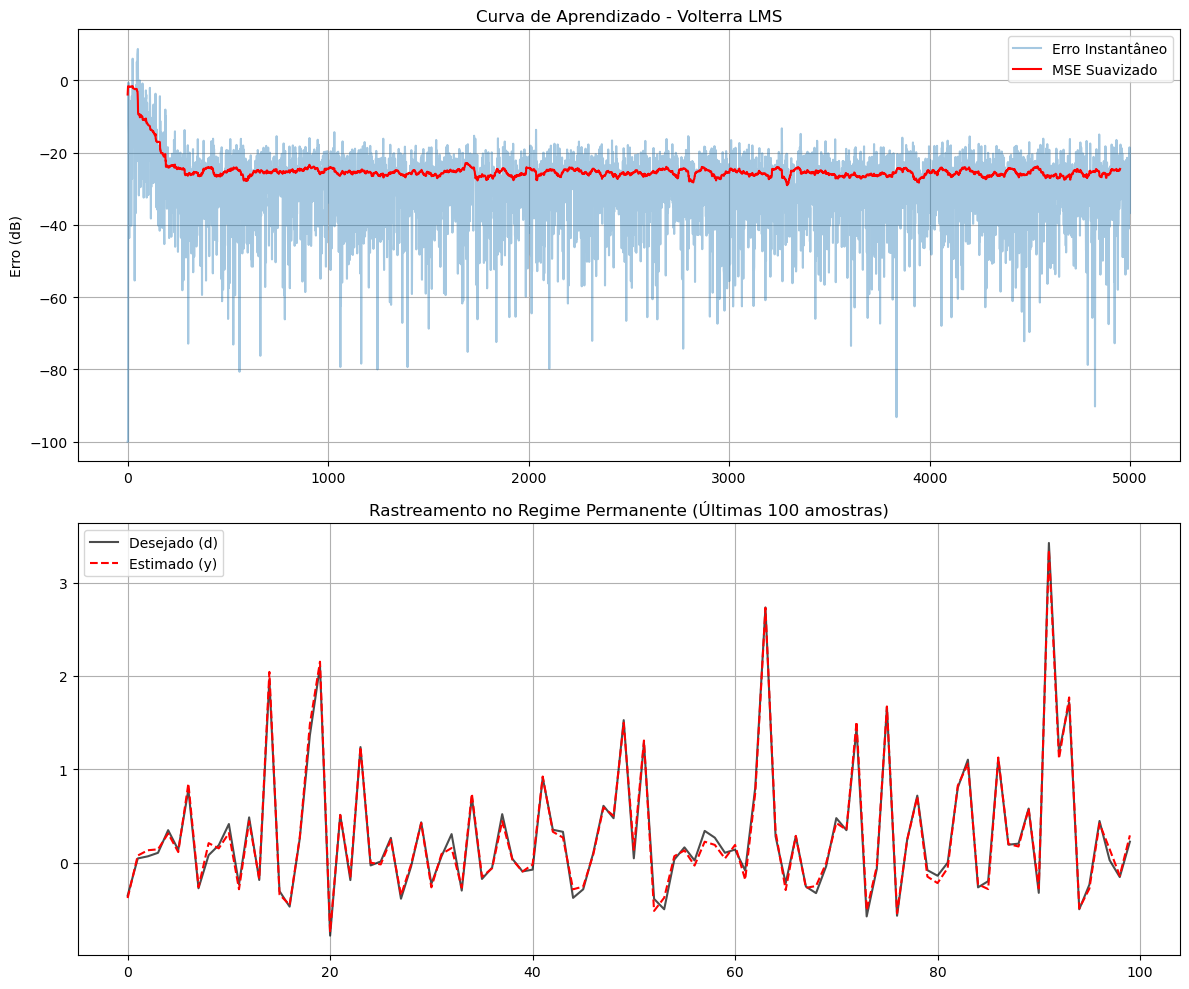

In [3]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# Curva de Aprendizado
ax[0].plot(10 * np.log10(e.real**2 + 1e-10), alpha=0.4, label="Erro Instantâneo")
# Média móvel para suavizar
error_smooth = np.convolve(e.real**2, np.ones(50)/50, mode='valid')
ax[0].plot(10 * np.log10(error_smooth + 1e-10), color='red', label="MSE Suavizado")
ax[0].set_title("Curva de Aprendizado - Volterra LMS")
ax[0].set_ylabel("Erro (dB)")
ax[0].legend()
ax[0].grid(True)

# Comparação de Sinais (Zoom no final)
ax[1].plot(d[-100:], 'k', label="Desejado (d)", alpha=0.7)
ax[1].plot(y[-100:], 'r--', label="Estimado (y)")
ax[1].set_title("Rastreamento no Regime Permanente (Últimas 100 amostras)")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()